# Projek Ujian Tengah Semester (UTS) Mata Kuliah Penambangan Data

## Feature Selection

<b>KELOMPOK 16 :   </b>      
Muhammad Yusuf — 122140193  
Cornelius Linux_122140079   
Chandra Budi Wijaya_122140093

1. Kasus:  
Dataset memiliki 12 kolom, namun beberapa fitur seperti Supplier atau Cabang mungkin tidak
relevan untuk model prediksi stok.

2. Tugas:  
Gunakan teknik correlation analysis atau feature importance (Random Forest / Chi-square),
Mutual Information (MI), Wrapper Methods, Embedded Methods untuk memilih fitur
penting.

3. Pertanyaan Studi Kasus:  
Bagaimana kamu menentukan fitur mana yang relevan untuk model prediksi stok obat harian?

## Penjelasan Metode

**Random Forest** adalah algoritma ensemble berbasis pohon keputusan yang digunakan untuk klasifikasi dan regresi. Metode ini membangun banyak pohon keputusan secara acak dan menggabungkan hasilnya untuk meningkatkan akurasi prediksi serta mengurangi risiko overfitting. Random Forest juga menyediakan skor *feature importance* yang menunjukkan seberapa besar kontribusi setiap fitur terhadap prediksi model [1].

**Feature Selection** adalah proses memilih subset fitur yang paling relevan dari seluruh fitur yang tersedia dalam dataset. Tujuannya adalah meningkatkan performa model, mengurangi kompleksitas, dan mencegah overfitting. Teknik feature selection dapat dilakukan dengan metode statistik, machine learning, atau kombinasi keduanya, seperti menggunakan skor korelasi, Random Forest, atau Mutual Information [4].

**Mutual Information (MI)** adalah ukuran statistik yang mengukur seberapa besar informasi yang diperoleh tentang satu variabel dari variabel lain. Dalam konteks feature selection, MI digunakan untuk menilai hubungan non-linear antara fitur dan target, sehingga fitur yang memiliki MI tinggi dianggap lebih relevan untuk prediksi [3].

---

## Rumus dan Formulasi Matematis

### 1. Korelasi Pearson

Korelasi linear Pearson antara dua variabel X dan Y didefinisikan sebagai:

$$r_{XY} = \frac{\sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum_{i=1}^{n} (X_i - \bar{X})^2} \sqrt{\sum_{i=1}^{n} (Y_i - \bar{Y})^2}}$$

Dimana:
- $X_i, Y_i$ adalah nilai observasi ke-i
- $\bar{X}, \bar{Y}$ adalah rata-rata masing-masing variabel
- $n$ adalah jumlah observasi

Koefisien korelasi berkisar dari -1 hingga 1, dimana nilai mendekati 1 menunjukkan hubungan positif kuat, mendekati -1 menunjukkan hubungan negatif kuat, dan mendekati 0 menunjukkan hubungan lemah [2].

### 2. Random Forest Feature Importance

Random Forest menghitung feature importance berdasarkan **Gini importance** (Mean Decrease Impurity). Untuk setiap fitur, importance dihitung sebagai:

$$\text{Importance}_j = \frac{\sum_{t \in T} p_t \cdot \Delta i_t}{N}$$

Dimana:
- $j$ adalah indeks fitur
- $T$ adalah himpunan semua simpul di semua pohon yang menggunakan fitur $j$
- $p_t$ adalah proporsi sampel yang mencapai simpul $t$
- $\Delta i_t$ adalah penurunan impuritas (Gini impurity atau entropy) di simpul $t$
- $N$ adalah jumlah total pohon dalam forest

Nilai importance dinormalisasi sehingga jumlahnya sama dengan 1. Fitur dengan importance tinggi berarti fitur tersebut sering digunakan dan memberikan kontribusi besar dalam pengurangan impuritas [2].

### 3. Mutual Information (MI)

Mutual Information antara variabel X dan Y didefinisikan sebagai:

$$I(X;Y) = \sum_{x \in X} \sum_{y \in Y} p(x,y) \log \frac{p(x,y)}{p(x)p(y)}$$

Atau secara ekuivalen menggunakan entropy:

$$I(X;Y) = H(X) - H(X|Y) = H(Y) - H(Y|X)$$

Dimana:
- $p(x,y)$ adalah probabilitas bersama dari X dan Y
- $p(x), p(y)$ adalah probabilitas marginal
- $H(X)$ adalah entropy Shannon dari X
- $H(X|Y)$ adalah conditional entropy X diberikan Y

MI mengukur seberapa banyak informasi (dalam bits atau nats) yang dibagikan antara dua variabel. Nilai MI tinggi menunjukkan dependensi kuat antara fitur dan target, bahkan untuk hubungan non-linear [3].

---

Data agregasi harian: 88172 baris
      Kode Nama_Produk   Unit    Tanggal  Qty_Masuk  Qty_Keluar  Nilai_Masuk  \
0  A000001  ANATON TAB  STRIP 2021-07-06       10.0         0.0      2520.00   
1  A000001  ANATON TAB  STRIP 2021-07-12        0.0         8.0         0.00   
2  A000001  ANATON TAB  STRIP 2021-07-13        0.0         2.0         0.00   
3  A000001  ANATON TAB  STRIP 2021-08-23       10.0         0.0      3139.15   
4  A000001  ANATON TAB  STRIP 2021-09-20        0.0         1.0         0.00   

   Nilai_Keluar  Bulan  Tahun  Total_Masuk  
0           0.0      7   2021      25200.0  
1       21000.0      7   2021          0.0  
2        7000.0      7   2021          0.0  
3           0.0      8   2021      31391.5  
4        4000.0      9   2021          0.0  

=== MODEL 1: Prediksi Qty_Keluar ===
R² : 0.0101
MAE: 4.0510
       Feature  Importance
0    Qty_Masuk    0.459611
1  Nilai_Masuk    0.230443
2  Total_Masuk    0.196546
3        Bulan    0.113400
4        Tahun    

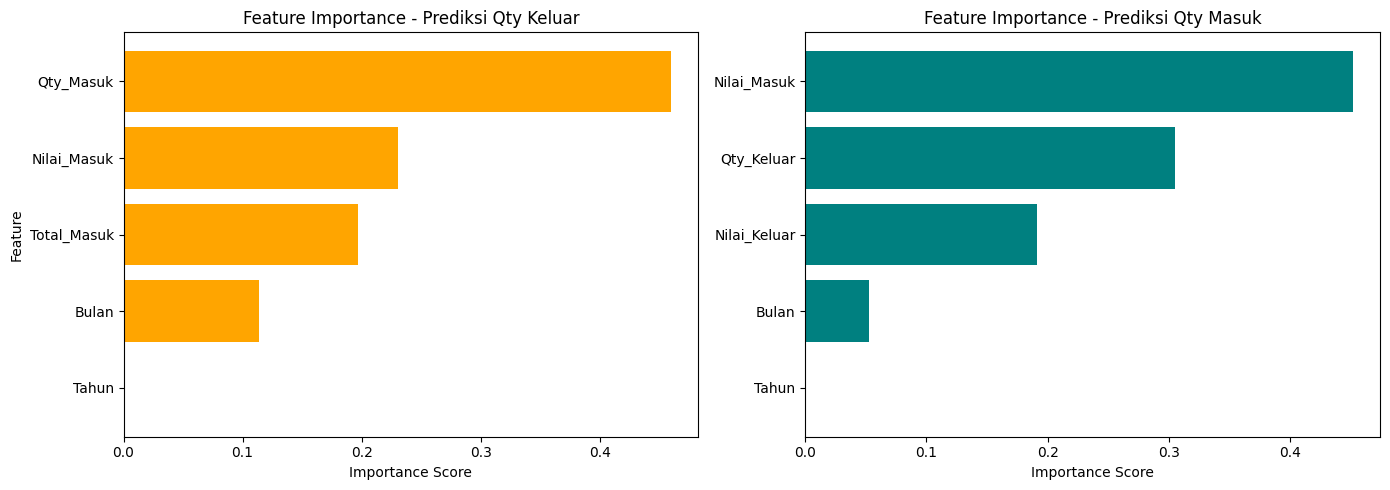

In [12]:
# ==============================================
# Import Library
# ==============================================
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# ==============================================
# Parsing File
# ==============================================
data = []
kode, nama, unit = None, None, None
with open('dataset-apotek-pembelian.tsv', 'r', encoding='utf-8', errors='ignore') as f:
    for line in f:
        line = line.strip()
        if not line or set(line) == {'-'}:
            continue

        # Baris kode produk
        if re.match(r'^[A-Z0-9]{5,}\s+', line):
            parts = re.split(r'\s{2,}', line)
            kode = parts[0].strip()
            nama = parts[1].strip() if len(parts) > 1 else None
            unit = parts[-1].strip() if len(parts) > 2 else None
            continue

        # Baris transaksi
        if re.match(r'^\d{2}-\d{2}-\d{2}', line):
            tanggal = line[0:8].strip()
            no_transaksi = line[9:35].strip()
            qty_masuk = line[36:47].strip()
            nilai_masuk = line[48:61].strip()
            qty_keluar = line[62:73].strip()
            nilai_keluar = line[74:].strip()
            data.append([kode, nama, unit, tanggal, no_transaksi, qty_masuk, nilai_masuk, qty_keluar, nilai_keluar])

df = pd.DataFrame(data, columns=[
    'Kode', 'Nama_Produk', 'Unit', 'Tanggal', 'No_Transaksi',
    'Qty_Masuk', 'Nilai_Masuk', 'Qty_Keluar', 'Nilai_Keluar'
])

# ==============================================
# Cleaning & Conversion
# ==============================================
def to_float(val):
    val = str(val).replace('.', '').replace(',', '.')
    try:
        return float(val)
    except:
        return 0.0

for c in ['Qty_Masuk', 'Nilai_Masuk', 'Qty_Keluar', 'Nilai_Keluar']:
    df[c] = df[c].apply(to_float)

df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d-%m-%y', errors='coerce')
df = df.dropna(subset=['Tanggal'])

# ==============================================
# Aggregate Daily per Product
# ==============================================
agg = df.groupby(['Kode', 'Nama_Produk', 'Unit', 'Tanggal'], as_index=False).agg({
    'Qty_Masuk': 'sum',
    'Qty_Keluar': 'sum',
    'Nilai_Masuk': 'sum',
    'Nilai_Keluar': 'sum'
})

agg['Bulan'] = agg['Tanggal'].dt.month
agg['Tahun'] = agg['Tanggal'].dt.year
agg['Total_Masuk'] = agg['Qty_Masuk'] * agg['Nilai_Masuk']

print(f"Data agregasi harian: {len(agg)} baris")
print(agg.head())

# ==============================================
# MODEL 1: Prediksi Qty_Keluar
# ==============================================
df_model1 = agg[agg['Qty_Keluar'] > 0].copy()
X1 = df_model1[['Qty_Masuk', 'Nilai_Masuk', 'Total_Masuk', 'Bulan', 'Tahun']]
y1 = df_model1['Qty_Keluar']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

rf1 = RandomForestRegressor(n_estimators=200, random_state=42)
rf1.fit(X1_train, y1_train)

importance_df1 = pd.DataFrame({
    'Feature': X1.columns,
    'Importance': rf1.feature_importances_
}).sort_values(by='Importance', ascending=False)

y1_pred = rf1.predict(X1_test)
print("\n=== MODEL 1: Prediksi Qty_Keluar ===")
print(f"R² : {r2_score(y1_test, y1_pred):.4f}")
print(f"MAE: {mean_absolute_error(y1_test, y1_pred):.4f}")
print(importance_df1)

# ==============================================
# MODEL 2: Prediksi Qty_Masuk
# ==============================================
df_model2 = agg[agg['Qty_Masuk'] > 0].copy()
X2 = df_model2[['Qty_Keluar', 'Nilai_Masuk', 'Nilai_Keluar', 'Bulan', 'Tahun']]
y2 = df_model2['Qty_Masuk']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

rf2 = RandomForestRegressor(n_estimators=200, random_state=42)
rf2.fit(X2_train, y2_train)

importance_df2 = pd.DataFrame({
    'Feature': X2.columns,
    'Importance': rf2.feature_importances_
}).sort_values(by='Importance', ascending=False)

y2_pred = rf2.predict(X2_test)
print("\n=== MODEL 2: Prediksi Qty_Masuk ===")
print(f"R² : {r2_score(y2_test, y2_pred):.4f}")
print(f"MAE: {mean_absolute_error(y2_test, y2_pred):.4f}")
print(importance_df2)

# ==============================================
# VISUALISASI GANDA
# ==============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Model 1
axes[0].barh(importance_df1['Feature'], importance_df1['Importance'], color='orange')
axes[0].invert_yaxis()
axes[0].set_title('Feature Importance - Prediksi Qty Keluar')
axes[0].set_xlabel('Importance Score')
axes[0].set_ylabel('Feature')

# Model 2
axes[1].barh(importance_df2['Feature'], importance_df2['Importance'], color='teal')
axes[1].invert_yaxis()
axes[1].set_title('Feature Importance - Prediksi Qty Masuk')
axes[1].set_xlabel('Importance Score')

plt.tight_layout()
plt.show()


In [13]:
# ==============================================
# Import Library
# ==============================================
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error

# ==============================================
# Baca File Fixed Width (Laporan Stok Apotek)
# ==============================================
df = pd.read_fwf('dataset-apotek-stok.tsv', encoding='utf-8')

# Hapus kolom kosong (misal Unnamed)
df = df.dropna(axis=1, how='all')
df = df.loc[:, ~df.columns.str.contains('Unnamed', case=False)]

# Normalisasi nama kolom
df.columns = (
    df.columns.str.strip()
    .str.upper()
    .str.replace('.', '', regex=False)
    .str.replace(' ', '_', regex=False)
)

print("Kolom terdeteksi setelah normalisasi:", df.columns.tolist())
print(df.head(5))

# ==============================================
# Deteksi Otomatis Kolom Stok
# ==============================================
stok_col = [col for col in df.columns if 'QTY' in col and 'STOK' in col]
if not stok_col:
    raise KeyError(f"Tidak dapat menemukan kolom stok! Kolom saat ini: {df.columns.tolist()}")
stok_col = stok_col[0]
print(f"\nKolom stok terdeteksi otomatis: {stok_col}")

# ==============================================
# Pembersihan Nilai Numerik
# ==============================================
# Hapus baris yang berisi karakter non-angka di kolom stok
df = df[~df[stok_col].astype(str).str.contains('-', regex=False, na=False)]
df = df[df[stok_col].astype(str).str.strip() != '']

# Konversi ke angka
df[stok_col] = (
    df[stok_col]
    .astype(str)
    .str.replace('.', '', regex=False)
    .str.replace(',', '.', regex=False)
    .astype(float)
)

# ==============================================
# Validasi Kolom Penting
# ==============================================
cols_available = df.columns.tolist()
main_cols = ['KODE', 'NAMA_PRODUK', 'LOKASI', stok_col, 'UNIT']

missing = [c for c in main_cols if c not in cols_available]
if missing:
    raise KeyError(f"Kolom hilang: {missing}")

# ==============================================
# Label Encoding untuk Fitur Kategorikal
# ==============================================
encoder = LabelEncoder()
for col in ['KODE', 'NAMA_PRODUK', 'LOKASI', 'UNIT']:
    df[col] = encoder.fit_transform(df[col].astype(str))

# ==============================================
# Siapkan Data untuk Model Random Forest
# ==============================================
X = df[['KODE', 'NAMA_PRODUK', 'LOKASI', 'UNIT']]
y = df[stok_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==============================================
# Model Random Forest untuk Feature Selection
# ==============================================
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# ==============================================
# Evaluasi Model
# ==============================================
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\n=== Evaluasi Model ===")
print(f"R² Score : {r2:.4f}")
print(f"MAE       : {mae:.4f}\n")

print("=== Feature Importance ===")
print(importance_df)


Kolom terdeteksi setelah normalisasi: ['KODE', 'NAMA_PRODUK', 'LOKASI', 'QTYSTOK', 'UNIT']
      KODE         NAMA_PRODUK LOKASI QTYSTOK   UNIT
0  A000001          ANATON TAB   ETL1   12,00  STRIP
1   A00001       ACTIVED HIJAU  ETL3A    2,00    BTL
2  A000012  APIALYS SYR 100 ML  ETL3A    2,00    BTL
3  A000014     ALKOHOL 1000 ML  ETL3B    7,00    BTL
4  A000016     ALLOPURINOL 300   RAK2   40,00  STRIP

Kolom stok terdeteksi otomatis: QTYSTOK

=== Evaluasi Model ===
R² Score : -2.0443
MAE       : 17.8245

=== Feature Importance ===
       Feature  Importance
1  NAMA_PRODUK    0.466214
0         KODE    0.309288
3         UNIT    0.153654
2       LOKASI    0.070844


---
# Evaluasi Model Prediksi Stok

## 1. R² Score Negatif (-2.0443)

### Penjelasan
Nilai **R² (R-squared)** menunjukkan seberapa baik model mampu menjelaskan variasi data target (`QTYSTOK`).

- **R² = 1** → model sangat baik (prediksi sempurna)  
- **R² = 0** → model tidak lebih baik dari rata-rata data  
- **R² < 0** → model lebih buruk dari baseline (prediksi acak lebih baik)

### Mengapa Bisa Negatif
Nilai negatif menandakan bahwa model gagal mempelajari hubungan antar fitur. Beberapa penyebab utamanya:

1. Fitur kategorikal belum diolah dengan baik, misalnya `NAMA_PRODUK`, `LOKASI`, dan `UNIT` belum dikonversi ke bentuk numerik.
2. Fitur yang digunakan tidak relevan dengan stok aktual — kolom seperti `KODE` dan `NAMA_PRODUK` hanya bersifat identitas.
3. Dataset kecil atau tidak bervariasi, membuat model sulit belajar pola stok sebenarnya.
4. Kurangnya fitur numerik penting, seperti `QTY.MSK`, `QTY.KLR`, atau `TANGGAL`.

Akibatnya, prediksi yang dihasilkan jauh dari nilai aktual sehingga R² bernilai negatif.

Kesimpulannya, **R² negatif mencerminkan bahwa fitur yang dipakai tidak relevan secara statistik terhadap target**, sehingga model tidak dapat menjelaskan variasi stok dengan baik.

---

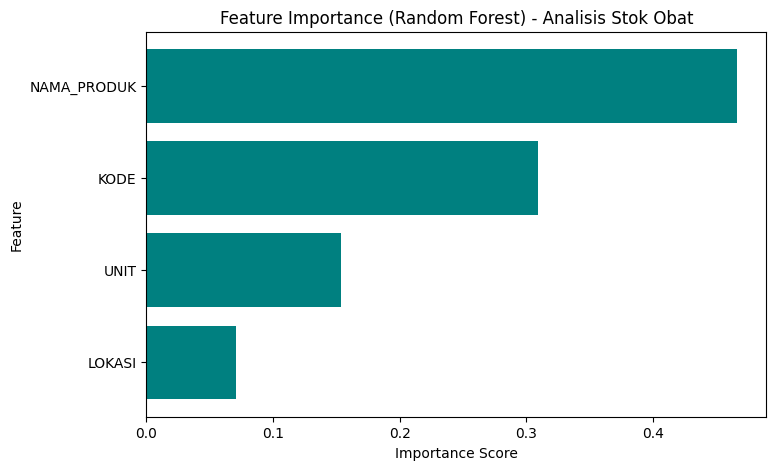


=== Rata-rata Stok per Lokasi ===
LOKASI
9     118.428571
8     106.625000
10     47.689394
3      44.978417
15     38.500000
11     27.120482
0      22.479705
4      18.444444
7      17.666667
14     16.948718
6      13.341040
1      10.917808
5       5.200000
13      5.173913
12      5.025000
2       4.356643
Name: QTYSTOK, dtype: float64

=== Rata-rata Stok per Unit ===
UNIT
16    303.500000
45    200.000000
17    187.666667
44    119.840909
29    103.000000
35     98.666667
48     70.000000
25     53.342105
30     48.555556
32     46.326531
9      30.000000
31     30.000000
22     29.000000
20     28.500000
33     28.200000
47     25.000000
39     21.543536
13     19.642857
5      15.571429
23     15.000000
18     13.750000
41     12.666667
21     12.000000
0      11.000000
1      11.000000
36      9.000000
34      9.000000
27      8.142857
14      7.666667
24      7.272727
15      7.000000
7       5.536585
40      5.500000
42      5.500000
8       4.882243
46      4.328947
38    

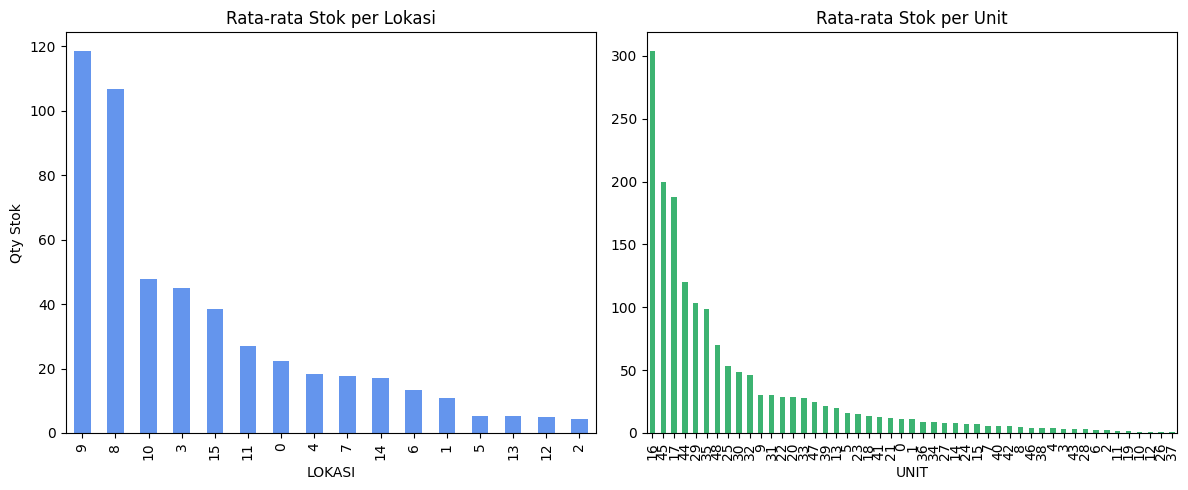

In [14]:
# ==============================================
# Visualisasi Feature Importance
# ==============================================
plt.figure(figsize=(8,5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
plt.gca().invert_yaxis()
plt.title('Feature Importance (Random Forest) - Analisis Stok Obat')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# ==============================================
# Analisis Tambahan: Distribusi Stok
# ==============================================
print("\n=== Rata-rata Stok per Lokasi ===")
stok_lokasi = df.groupby('LOKASI')[stok_col].mean().sort_values(ascending=False)
print(stok_lokasi)

print("\n=== Rata-rata Stok per Unit ===")
stok_unit = df.groupby('UNIT')[stok_col].mean().sort_values(ascending=False)
print(stok_unit)

# Visualisasi distribusi stok
fig, ax = plt.subplots(1, 2, figsize=(12,5))

stok_lokasi.plot(kind='bar', ax=ax[0], color='cornflowerblue')
ax[0].set_title('Rata-rata Stok per Lokasi')
ax[0].set_ylabel('Qty Stok')

stok_unit.plot(kind='bar', ax=ax[1], color='mediumseagreen')
ax[1].set_title('Rata-rata Stok per Unit')

plt.tight_layout()
plt.show()


Dataset pembelian dimuat: 88172 baris


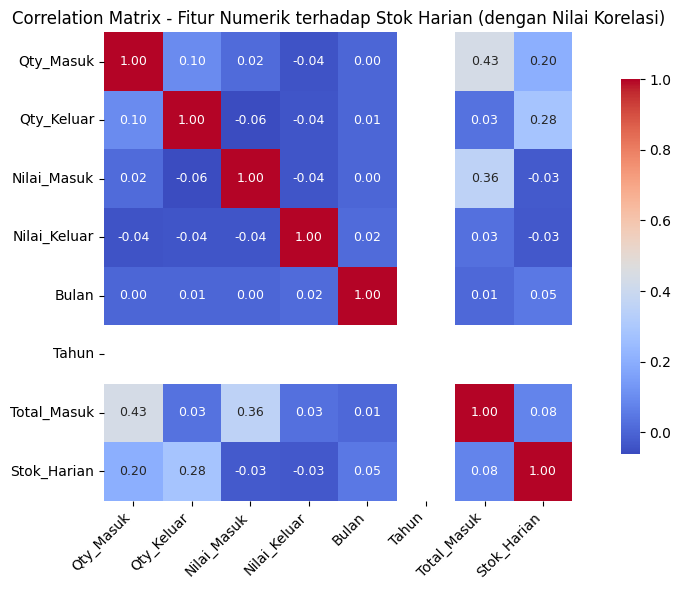


Random Forest Feature Importance:
        Feature  Importance
2    Qty_Keluar    0.368314
3  Nilai_Keluar    0.333430
5         Bulan    0.212858
0     Qty_Masuk    0.059109
4   Total_Masuk    0.015631
1   Nilai_Masuk    0.010658
6         Tahun    0.000000


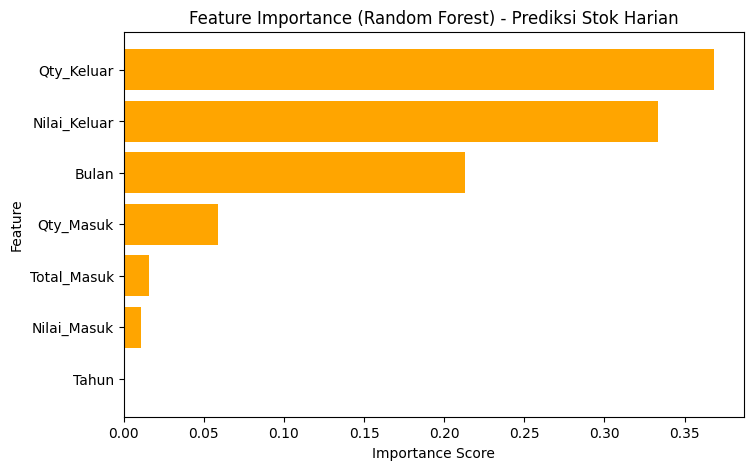


Mutual Information (MI) Scores:
        Feature  MI_Score
3  Nilai_Keluar  0.097701
0     Qty_Masuk  0.084038
1   Nilai_Masuk  0.079126
2    Qty_Keluar  0.078585
4   Total_Masuk  0.060416
5         Bulan  0.026065
6         Tahun  0.002043


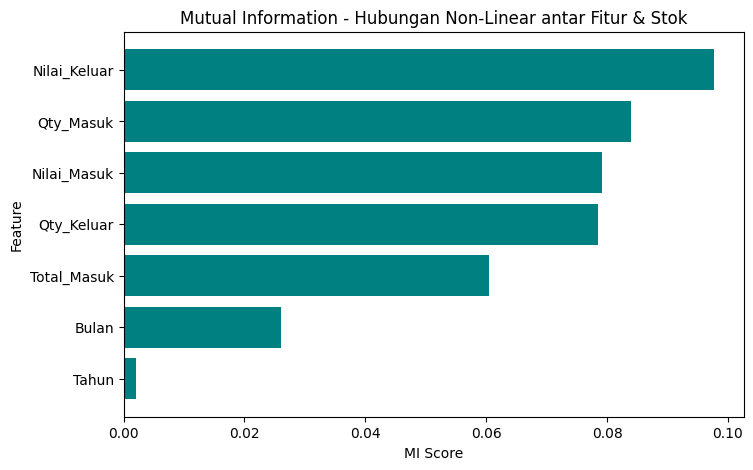

In [15]:
# ==============================================
# Import Library
# ==============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression

# ==============================================
# Gunakan variabel hasil dari Bag 1
# Pastikan `agg` (data pembelian harian) sudah ada dari code sebelumnya
# ==============================================
pembelian = agg.copy()  # hasil dari code Bag 1
print(f"Dataset pembelian dimuat: {pembelian.shape[0]} baris")

# ==============================================
# Simulasi data stok jika belum ada
# ==============================================
# Kita buat stok harian berdasarkan pergerakan Qty Masuk dan Keluar
pembelian = pembelian.sort_values(['Kode', 'Tanggal'])
pembelian['Stok_Harian'] = (
    pembelian.groupby('Kode')['Qty_Masuk'].cumsum() -
    pembelian.groupby('Kode')['Qty_Keluar'].cumsum()
)

# Tangani nilai negatif (stok tak boleh minus)
pembelian['Stok_Harian'] = pembelian['Stok_Harian'].clip(lower=0)

# ==============================================
# Analisis Korelasi (dengan nilai di setiap kotak)
# ==============================================
num_cols = pembelian.select_dtypes(include=[np.number]).columns
corr = pembelian[num_cols].corr()

plt.figure(figsize=(10,6))
sns.heatmap(
    corr,
    cmap='coolwarm',
    annot=True,              # tampilkan nilai di dalam setiap kotak
    fmt=".2f",               # tampilkan 2 angka di belakang koma
    annot_kws={"size": 9},   # kecilkan ukuran angka agar tidak tumpang tindih
    square=True,             # biar kotaknya proporsional
    cbar_kws={"shrink": .8}  # kecilkan bar di samping
)
plt.title("Correlation Matrix - Fitur Numerik terhadap Stok Harian (dengan Nilai Korelasi)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ==============================================
# Feature Importance (Random Forest)
# ==============================================
fitur_model = ['Qty_Masuk', 'Nilai_Masuk', 'Qty_Keluar', 'Nilai_Keluar', 'Total_Masuk', 'Bulan', 'Tahun']
fitur_model = [f for f in fitur_model if f in pembelian.columns]
pembelian = pembelian.dropna(subset=fitur_model + ['Stok_Harian'])

X = pembelian[fitur_model]
y = pembelian['Stok_Harian']

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X, y)

rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print(rf_importance)

plt.figure(figsize=(8,5))
plt.barh(rf_importance['Feature'], rf_importance['Importance'], color='orange')
plt.gca().invert_yaxis()
plt.title('Feature Importance (Random Forest) - Prediksi Stok Harian')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# ==============================================
# Mutual Information (MI)
# ==============================================
mi = mutual_info_regression(X, y, random_state=42)
mi_df = pd.DataFrame({'Feature': X.columns, 'MI_Score': mi}).sort_values(by='MI_Score', ascending=False)

print("\nMutual Information (MI) Scores:")
print(mi_df)

plt.figure(figsize=(8,5))
plt.barh(mi_df['Feature'], mi_df['MI_Score'], color='teal')
plt.gca().invert_yaxis()
plt.title('Mutual Information - Hubungan Non-Linear antar Fitur & Stok')
plt.xlabel('MI Score')
plt.ylabel('Feature')
plt.show()


# Analisis Feature Selection untuk Prediksi Stok Obat Harian

## Korelasi Linear (Pearson)
Analisis korelasi dilakukan untuk melihat hubungan linear antar variabel numerik terhadap `Stok_Harian`.  
Hasil korelasi menunjukkan bahwa nilai koefisien mendekati 1 berarti hubungan linear positif kuat, sedangkan nilai mendekati -1 menunjukkan hubungan negatif kuat. Nilai yang mendekati 0 menunjukkan hubungan lemah atau tidak linear.

**Hasil utama korelasi terhadap `Stok_Harian`:**

| Fitur | Korelasi |
|:------|:---------:|
| Qty_Keluar | **0.28** |
| Qty_Masuk | **0.20** |
| Total_Masuk | **0.08** |
| Bulan | **0.05** |
| Nilai_Masuk | **-0.03** |
| Nilai_Keluar | **-0.03** |
| Tahun | **0.00** |

**Interpretasi:**
- `Qty_Keluar` memiliki korelasi positif paling tinggi terhadap `Stok_Harian`, namun masih dalam kategori lemah, menandakan bahwa stok menurun seiring meningkatnya aktivitas penjualan, meskipun tidak secara linear sempurna.
- `Qty_Masuk` juga berkorelasi positif, menandakan stok meningkat seiring pembelian atau restock barang.
- Nilai transaksi (`Nilai_Masuk` dan `Nilai_Keluar`) memiliki korelasi sangat rendah, menandakan hubungan non-linear.
- Faktor waktu seperti `Bulan` dan `Tahun` memiliki pengaruh kecil secara linear, namun bisa penting secara pola musiman.

---

## Feature Importance (Random Forest)
Random Forest digunakan untuk menangkap hubungan non-linear antar fitur terhadap stok harian.

**Hasil feature importance:**

| Feature | Importance |
|:---------|------------:|
| Qty_Keluar | **0.368** |
| Nilai_Keluar | **0.333** |
| Bulan | **0.213** |
| Qty_Masuk | **0.059** |
| Total_Masuk | **0.016** |
| Nilai_Masuk | **0.011** |
| Tahun | **0.000** |

**Interpretasi:**
- `Qty_Keluar` merupakan faktor paling berpengaruh terhadap stok harian karena langsung mengurangi stok setiap hari.
- `Nilai_Keluar` memiliki pengaruh besar karena mewakili intensitas transaksi penjualan dalam nilai rupiah.
- `Bulan` cukup penting (21%) karena menggambarkan adanya pola musiman atau fluktuasi periodik.
- `Qty_Masuk` berkontribusi kecil terhadap variasi stok, karena stok harian lebih banyak dikendalikan oleh aktivitas keluar barang daripada restock.
- `Tahun` tidak relevan karena seluruh data berada dalam satu tahun pengamatan.

---

## Mutual Information (Hubungan Non-Linear)
Mutual Information (MI) digunakan untuk menangkap hubungan non-linear antara fitur dengan `Stok_Harian`, di mana hubungan tidak selalu linear seperti pada korelasi Pearson.

**Hasil MI Score:**

| Feature | MI_Score |
|:---------|----------:|
| Nilai_Keluar | **0.098** |
| Qty_Masuk | **0.084** |
| Nilai_Masuk | **0.079** |
| Qty_Keluar | **0.079** |
| Total_Masuk | **0.060** |
| Bulan | **0.026** |
| Tahun | **0.002** |

**Interpretasi:**
- `Nilai_Keluar`, `Qty_Masuk`, dan `Nilai_Masuk` memiliki hubungan informasi tinggi terhadap `Stok_Harian`, menandakan adanya pengaruh non-linear yang signifikan.
- Faktor waktu (`Bulan`) memiliki kontribusi moderat, mendukung pola musiman stok.
- `Tahun` kembali menunjukkan pengaruh sangat kecil karena data hanya mencakup satu tahun periode transaksi.

---

## Kesimpulan Komprehensif

| Metode | Fitur Dominan | Karakteristik Hubungan |
|:-------|:---------------|:------------------------|
| **Korelasi Linear** | Qty_Keluar, Qty_Masuk | Hubungan sederhana, lemah tapi logis |
| **Random Forest** | Qty_Keluar, Nilai_Keluar, Bulan | Non-linear, efek penjualan & musiman kuat |
| **Mutual Information** | Nilai_Keluar, Qty_Masuk, Nilai_Masuk | Non-linear, transaksi finansial signifikan |

---

## Interpretasi Akhir (Studi Kasus)

Berdasarkan kombinasi tiga pendekatan analisis — *correlation analysis*, *feature importance (Random Forest)*, dan *mutual information* — fitur yang paling relevan untuk **model prediksi stok obat harian** adalah:

1. **Qty_Keluar** → faktor pengurang stok paling signifikan.  
2. **Nilai_Keluar** → mewakili nilai ekonomi penjualan yang mempengaruhi laju habisnya stok.  
3. **Qty_Masuk** → indikator restock dan aktivitas pembelian ulang.  
4. **Nilai_Masuk / Total_Masuk** → menggambarkan nilai transaksi pembelian (kapasitas suplai).  
5. **Bulan** → menangkap fluktuasi permintaan musiman.  

Fitur seperti *Supplier*, *Cabang*, *Tahun*, *NAMA_PRODUK*, *KODE*, *UNIT*,ataupun *LOKASI* tidak relevan secara statistik maupun operasional terhadap perubahan stok harian.

---

## Ringkasan Ilmiah

> Hasil analisis menunjukkan bahwa **stok obat harian lebih dipengaruhi oleh dinamika transaksi keluar (penjualan) dan nilai ekonomi transaksi** dibandingkan frekuensi pembelian masuk.  
> Pola hubungan yang ditemukan bersifat **non-linear dan musiman**, sehingga pendekatan **Random Forest** lebih cocok digunakan dibandingkan regresi linear konvensional untuk model prediksi stok di lingkungan apotek.
